### Mount Drive and Import Pacakges

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
%matplotlib inline

## 1. Data

### Load and prepare data

In [ ]:
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
root

'/content/drive/MyDrive/Colab Notebooks/data'

In [ ]:
def get_data(data, root, download=True, transform=transforms.ToTensor()):
  if data.lower() == "mnist":
    train = datasets.MNIST(
        root=root, 
        train=True, 
        download=download, 
        transform=transform)
    test = datasets.MNIST(
        root=root, 
        train=False, 
        download=download, 
        transform=transform)
  
  elif data.lower() == "fmnist":
    train = datasets.FashionMNIST(
        root=root, 
        train=True, 
        download=download, 
        transform=transform)
    test = datasets.FashionMNIST(
        root=root, 
        train=False, 
        download=download, 
        transform=transform)
  
  else:
    raise ValueError(f"data name {data} is not supported.")

  return train, test

mnist_tr, mnist_test = get_data(data="MNIST", root=root)
fmnist_tr, fmnist_test = get_data(data="FMNIST", root=root)

In [ ]:
sample_mnist_x, sample_mnist_y = mnist_tr[0]
print(sample_mnist_x.shape)
print(mnist_tr.targets.shape)
print(mnist_tr.targets.unique())

torch.Size([1, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
sample_fmnist_x, sample_fmnist_y = fmnist_tr[0]
print(sample_fmnist_x.shape)
print(fmnist_tr.targets.shape)
print(fmnist_tr.targets.unique())

torch.Size([1, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


### Check datasets

In [ ]:
def plot_mnist(data, figsize=(10, 7)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    img = data[i][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(img.reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {data[i][1]}")
  fig.show()
  pass

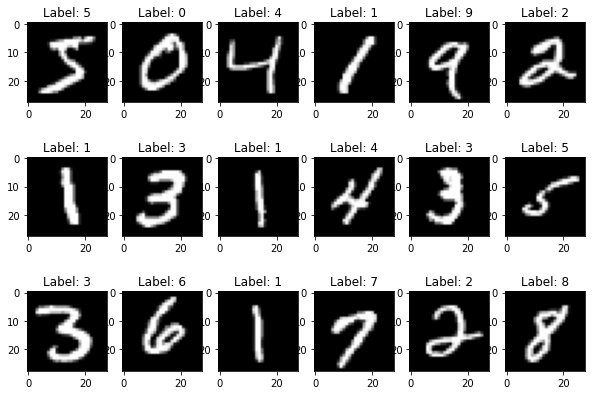

In [ ]:
plot_mnist(data=mnist_tr)

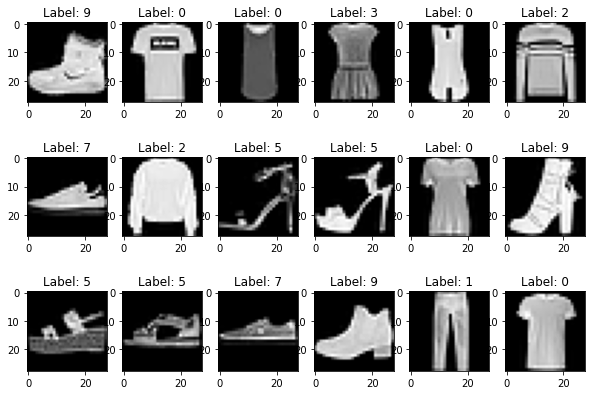

In [ ]:
plot_mnist(data=fmnist_tr)

### Split train dataset into train and valid

In [ ]:
class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

In [ ]:
def split_train_valid(dataset, valid_ratio=0.1):
  n_valid = int(len(dataset) * valid_ratio)

  random.Random(2022).shuffle(dataset.data)
  random.Random(2022).shuffle(dataset.targets)

  train_data = dataset.data[:-n_valid].numpy()
  valid_data = dataset.data[-n_valid:].numpy()

  train_targets = dataset.targets[:-n_valid]
  valid_targets = dataset.targets[-n_valid:]

  train = mnist_dataset(data = train_data, targets = train_targets, transform = dataset.transform, target_transform = dataset.target_transform)
  valid = mnist_dataset(data = valid_data, targets = valid_targets, transform = dataset.transform, target_transform = dataset.target_transform)

  return train, valid

In [ ]:
mnist_train, mnist_valid = split_train_valid(dataset=mnist_tr)
fmnist_train, fmnist_valid = split_train_valid(dataset=fmnist_tr)

### Check shuffling result

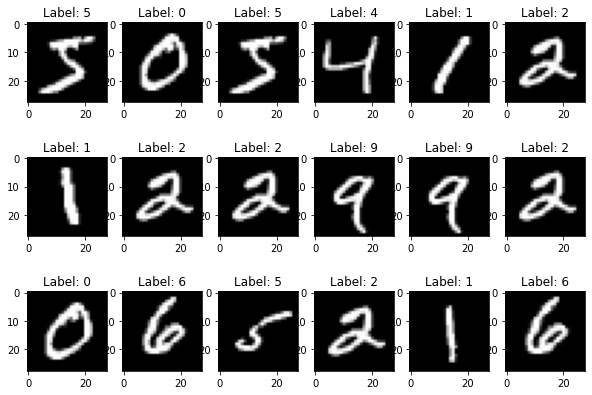

In [ ]:
plot_mnist(data=mnist_train)

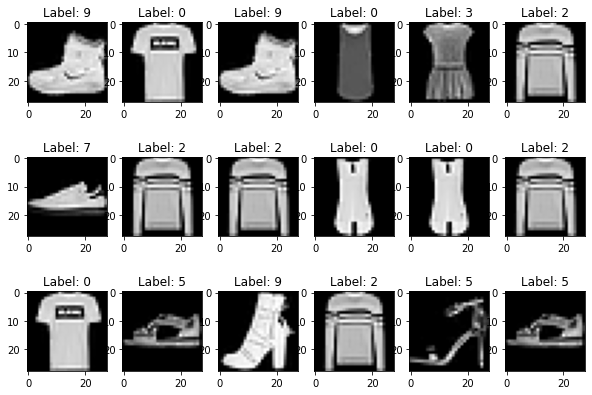

In [ ]:
plot_mnist(data=fmnist_train)

In [ ]:
mnists = {}
mnists["mnist"] = {"train": mnist_train, "valid": mnist_valid, "test": mnist_test}
mnists["fmnist"] = {"train": fmnist_train, "valid": fmnist_valid, "test": fmnist_test}
for k in mnists.keys():
  print(f"Length of {k}: train = {len(mnists[k]['train'])}, valid = {len(mnists[k]['valid'])}, test = {len(mnists[k]['test'])}.")

Length of mnist: train = 54000, valid = 6000, test = 10000.
Length of fmnist: train = 54000, valid = 6000, test = 10000.


### Get loaders

In [ ]:
b_size = 256
mnist = [DataLoader(dataset=d, batch_size=b_size, shuffle=True, drop_last=True) for d in [mnist_train, mnist_valid, mnist_test]]
fmnist = [DataLoader(dataset=d, batch_size=b_size, shuffle=True, drop_last=True) for d in [fmnist_train, fmnist_valid, fmnist_test]]
datas = {"mnist": mnist, "fmnist": fmnist}
datas

{'fmnist': [<torch.utils.data.dataloader.DataLoader at 0x7f3b4aa4fa90>,
 'mnist': [<torch.utils.data.dataloader.DataLoader at 0x7f3b4aa4f9d0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f3b4aeec810>]}

## 2. Model

### Base model

In [ ]:
class BaseClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "base"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, n_class),
    )

  def forward(self, x):
    return self.model(x)

### Customized models

In [ ]:
class FirstClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "first"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class SecondClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "second"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(512,128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class ThirdClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "third"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512,128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class FourthClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "fourth"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(256,128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class FifthClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "fifth"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class SixthClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "sixth"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(256,128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.3),
        nn.LeakyReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class SeventhClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "seventh"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)



### Using get_model function

In [ ]:
def get_model(model_name):
  if model_name.lower() == "base":
    return BaseClassifier()
  elif model_name.lower() == "first":
    return FirstClassifier()
  elif model_name.lower() == "second":
    return SecondClassifier()
  elif model_name.lower() == 'third':
    return ThirdClassifier()
  elif model_name.lower() == 'fourth':
    return FourthClassifier()
  elif model_name.lower() == 'fifth':
    return FifthClassifier()
  elif model_name.lower() == 'sixth':
    return SixthClassifier()
  elif model_name.lower() == 'seventh':
    return SeventhClassifier()
  else:
    raise ValueError(f"model name {model_name} is not supported")


## 3. Trainer

### Make trainer

In [ ]:
class Trainer(nn.Module):
  def __init__(self, model, opt="sgd", lr=0.001, device="cpu"):
    super().__init__()
    self.path = f"_model_{model.name}_opt_{opt}_lr_{lr}"

    self.model = model
    self.loss = nn.CrossEntropyLoss()
    self._get_optimizer(opt=opt.lower(), lr=lr)

    self.device = device
    pass

  def _get_optimizer(self, opt, lr=0.001):
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    elif opt == "rmsprop":
      self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
    
    else:
      raise ValueError(f"optimizer {opt} is not supproted")

  def train(self, data_name, train_loader, valid_loader, max_epochs=10):
    print("===== Train Start =====")
    start_time = time.time()
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch(train_loader)
      valid_loss, valid_acc = self._valid_epoch(valid_loader)

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      if e % 5 == 0:
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}, time: {time.time()-start_time:>3f}")
        start_time = time.time()

    self.plot_history(history, data_name, max_epochs)

  def _train_epoch(self, train_loader):
    epoch_loss, epoch_acc = 0, 0
    self.model.train()
    for (x, y) in train_loader:
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)
      loss = self.loss(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_loss += loss.to("cpu").item()
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)
  
  def _valid_epoch(self, valid_loader):
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

  
  
  def plot_history(self, history, data_name, max_epochs):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    plt.suptitle(f"Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs}", fontsize=12, fontweight='bold')

    path = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "plots", f"data_{data_name}" + self.path + f"_max_epochs_{max_epochs}.png")
    plt.savefig(path, bbox_inches="tight")
    pass

  def test(self, test_loader):
    print("===== Test Start =====")
    start_time = time.time()
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(test_loader)
    epoch_acc /= len(test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}, time: {time.time()-start_time:>3f}")
    print("--------------------------------------------------------")
    print()
    print()

### Train and test

In [ ]:
p = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "plots")
if not os.path.isdir(p):
  os.mkdir(p)

In [ ]:
ds = ["mnist", "fmnist"]
models = ["base", "first", "second", "third"]
opts = ["sgd", "adam", "rmsprop"]
lrs = [0.001, 0.005, 0.01]
max_epochs = 40

===== Data: mnist, Model: base, Optimizer: sgd, lr: 0.001, max_epochs: 40 =====
===== Train Start =====
Epoch: 0, train loss: 2.299751, train acc: 0.100837, valid loss: 2.297551, valid acc: 0.112092, time: 2.580935
Epoch: 5, train loss: 2.272345, train acc: 0.247675, valid loss: 2.269328, valid acc: 0.253906, time: 12.521153
Epoch: 10, train loss: 2.229089, train acc: 0.344475, valid loss: 2.223928, valid acc: 0.358186, time: 11.911093
Epoch: 15, train loss: 2.157191, train acc: 0.368304, valid loss: 2.148265, valid acc: 0.378057, time: 11.823105
Epoch: 20, train loss: 2.042449, train acc: 0.401153, valid loss: 2.028629, valid acc: 0.414912, time: 12.179525
Epoch: 25, train loss: 1.873771, train acc: 0.488802, valid loss: 1.854032, valid acc: 0.509171, time: 12.280251
Epoch: 30, train loss: 1.636616, train acc: 0.612481, valid loss: 1.612953, valid acc: 0.618207, time: 12.093723
Epoch: 35, train loss: 1.344043, train acc: 0.696466, valid loss: 1.319843, valid acc: 0.698370, time: 12.08

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Training time : 274.897166
===== Test Start =====
Test loss: 0.089921, Test acc: 0.973458, time: 1.203372
--------------------------------------------------------


===== Data: mnist, Model: second, Optimizer: adam, lr: 0.001, max_epochs: 40 =====
===== Train Start =====
Epoch: 0, train loss: 0.325116, train acc: 0.914044, valid loss: 0.104418, valid acc: 0.967731, time: 8.882460
Epoch: 5, train loss: 0.027181, train acc: 0.991611, valid loss: 0.062083, valid acc: 0.984035, time: 37.815936
Epoch: 10, train loss: 0.015554, train acc: 0.994922, valid loss: 0.060853, valid acc: 0.984205, time: 38.188918
Epoch: 15, train loss: 0.009851, train acc: 0.996838, valid loss: 0.069834, valid acc: 0.985224, time: 38.286619
Epoch: 20, train loss: 0.008350, train acc: 0.997228, valid loss: 0.080230, valid acc: 0.984375, time: 38.033233
Epoch: 25, train loss: 0.005555, train acc: 0.998233, valid loss: 0.064078, valid acc: 0.987432, time: 38.295022
Epoch: 30, train loss: 0.005220, train acc: 0.998326,

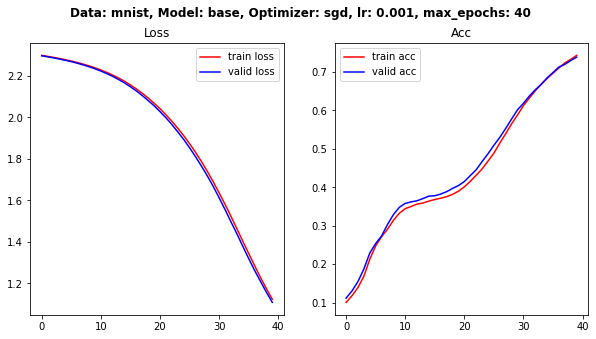

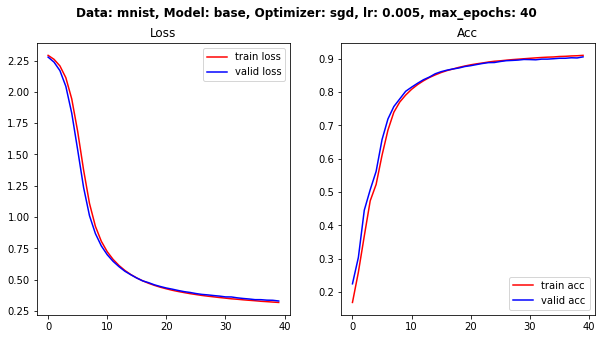

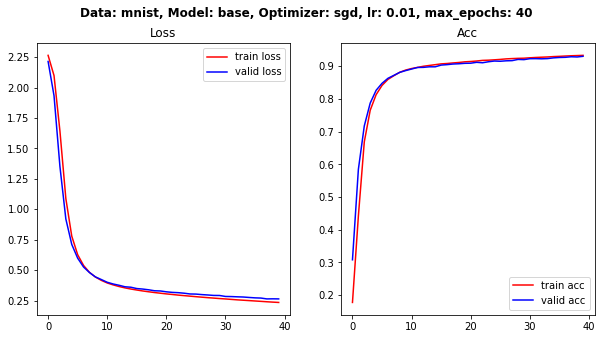

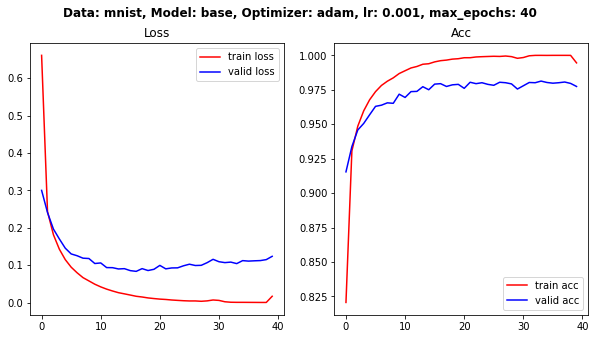

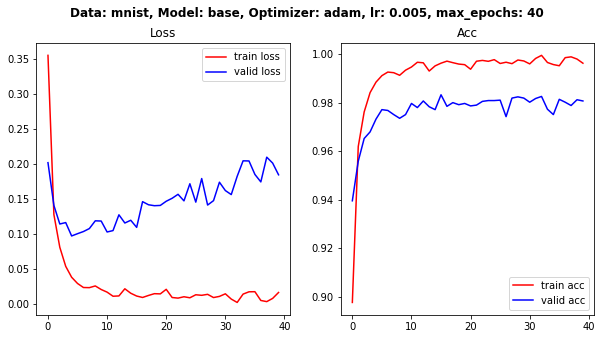

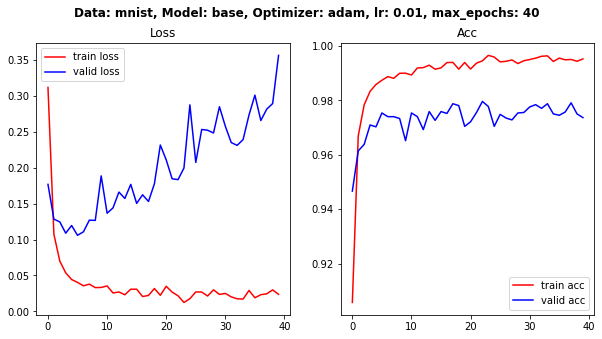

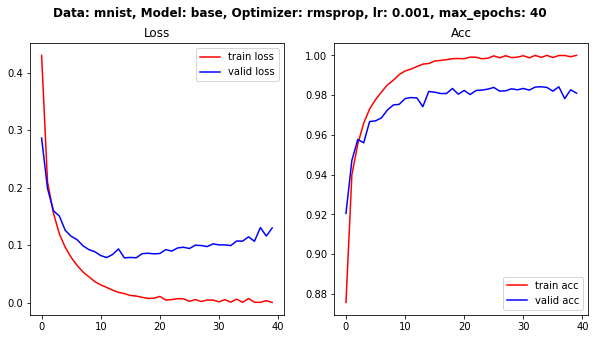

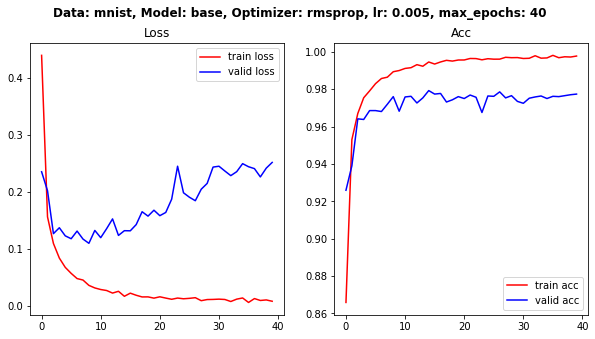

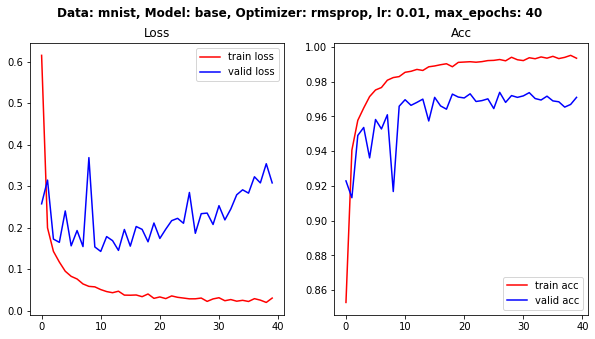

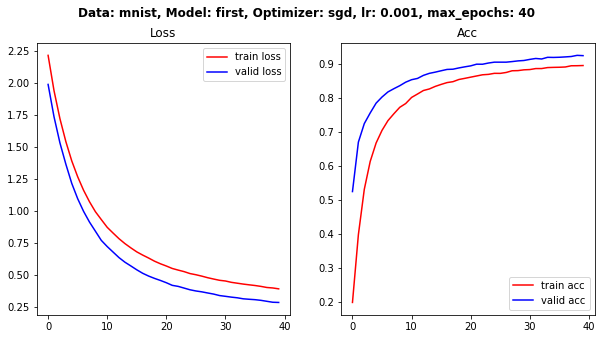

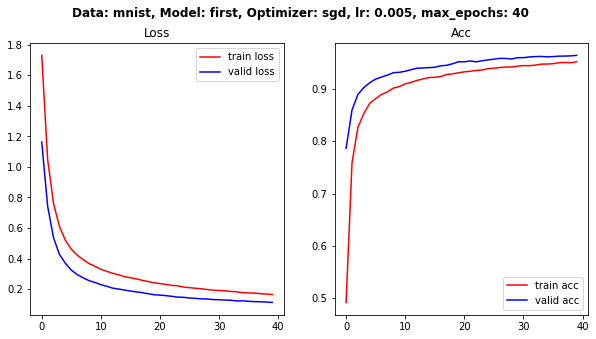

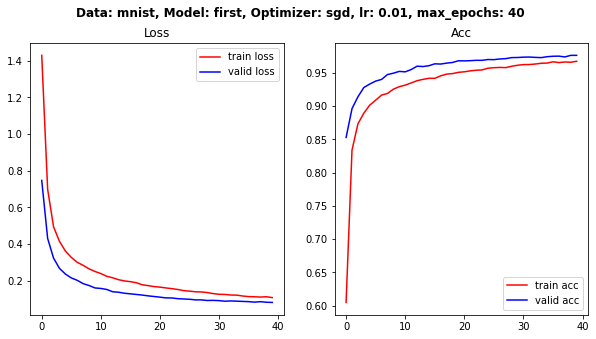

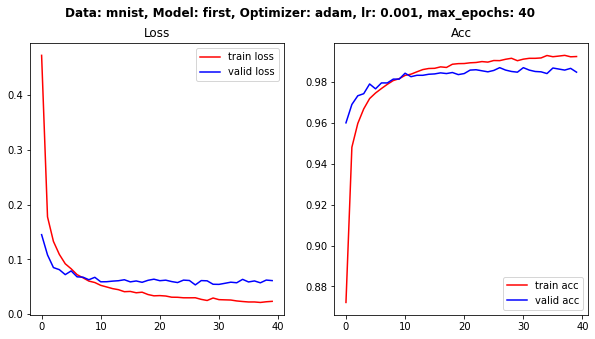

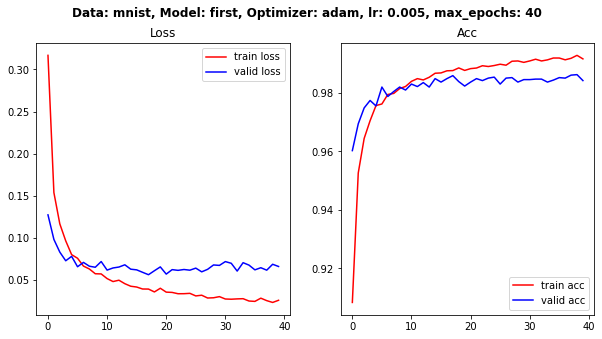

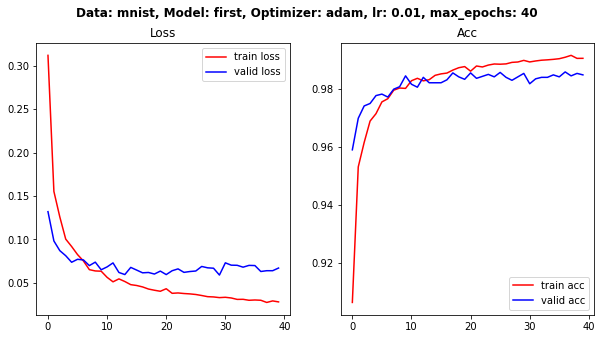

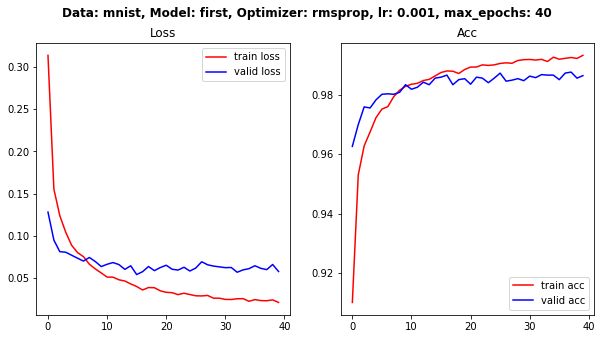

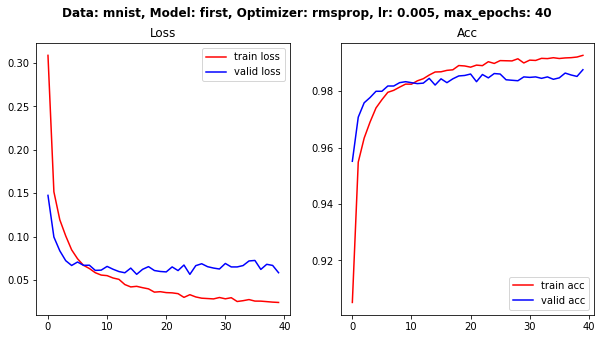

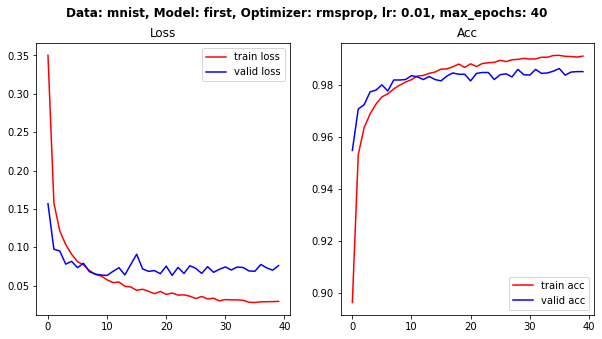

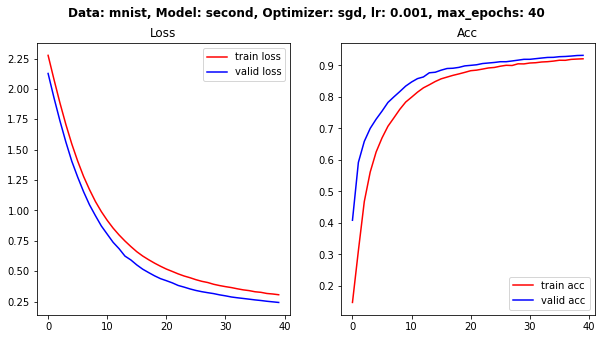

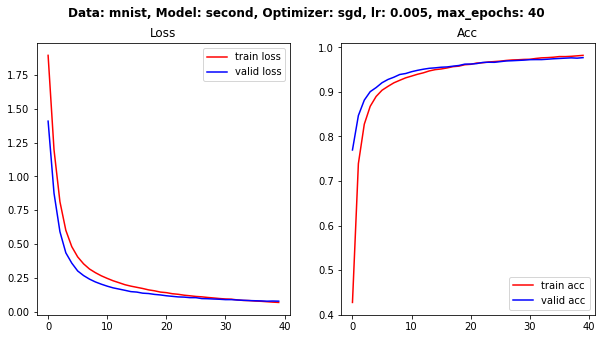

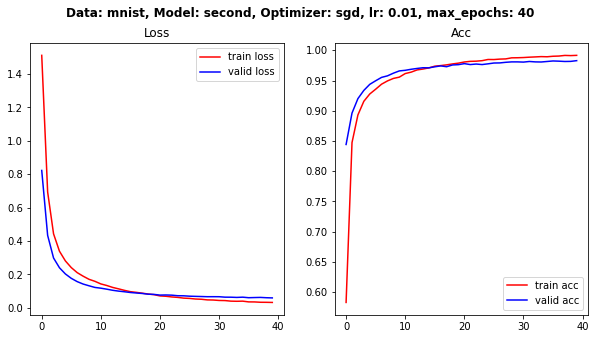

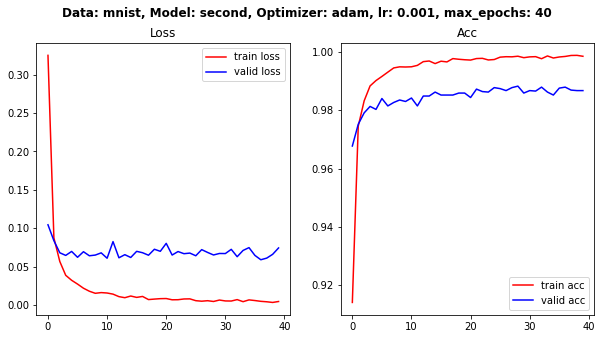

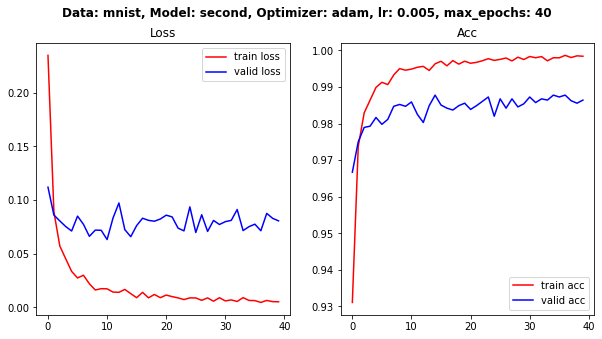

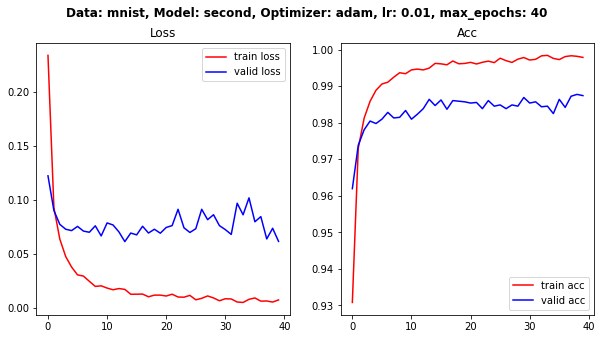

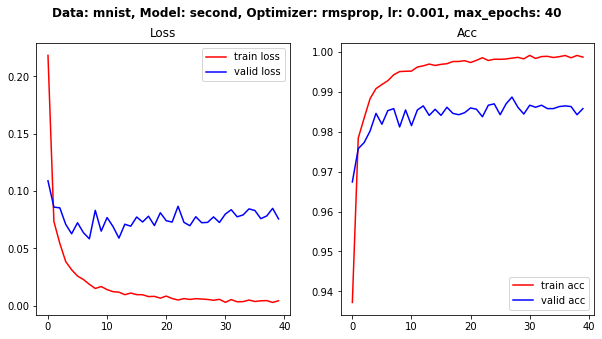

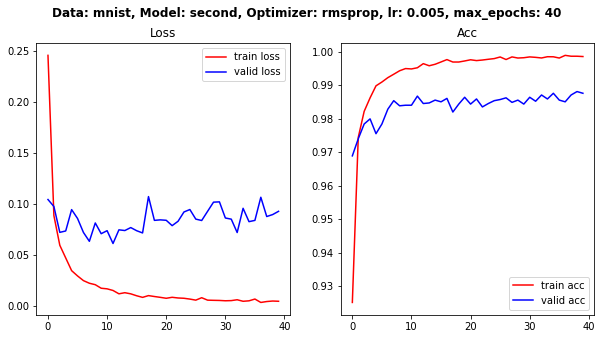

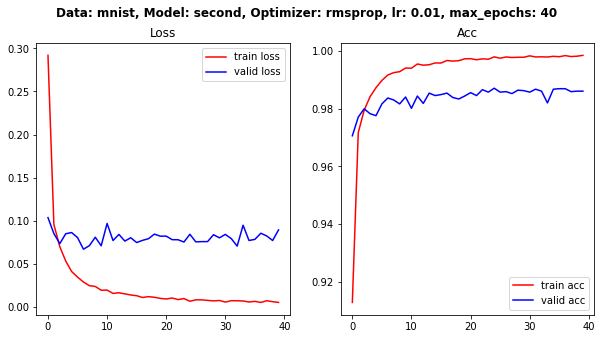

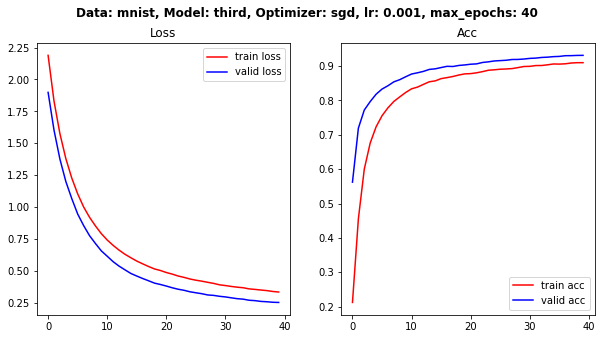

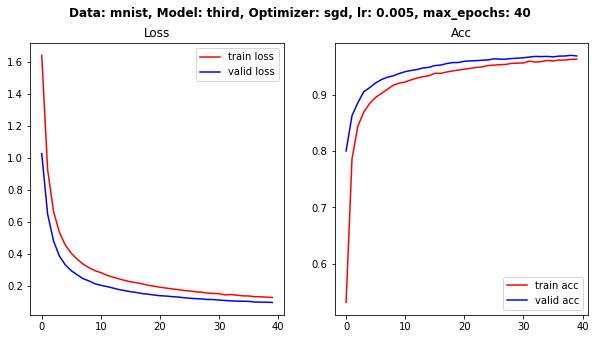

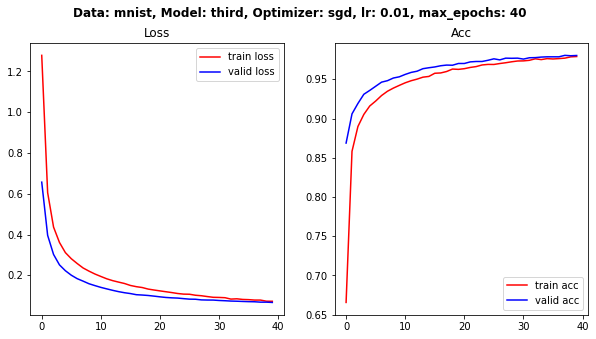

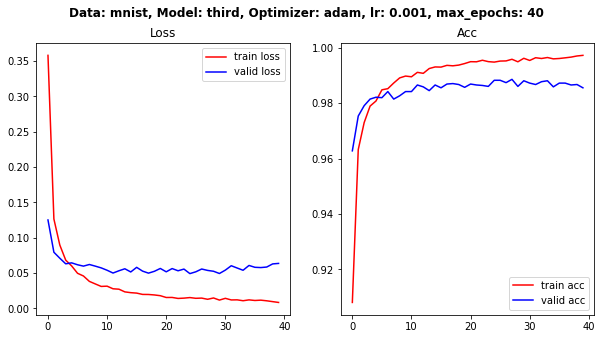

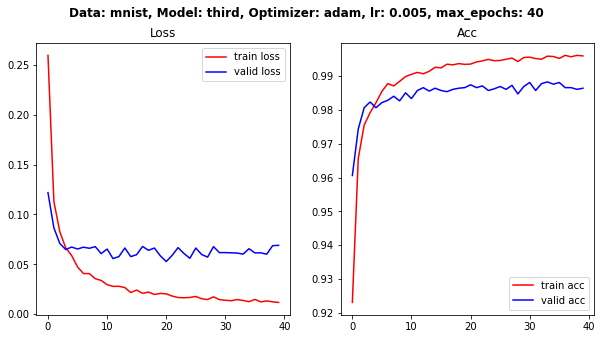

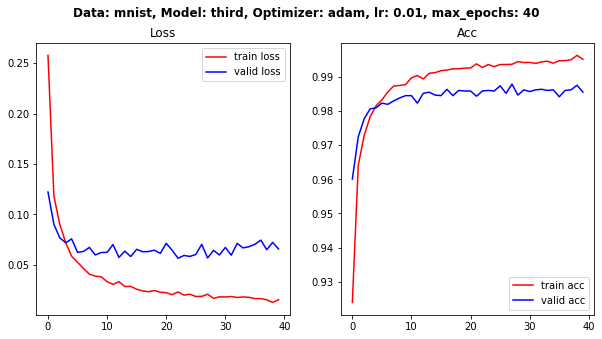

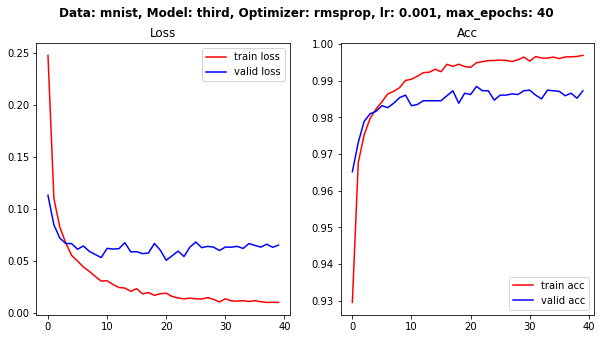

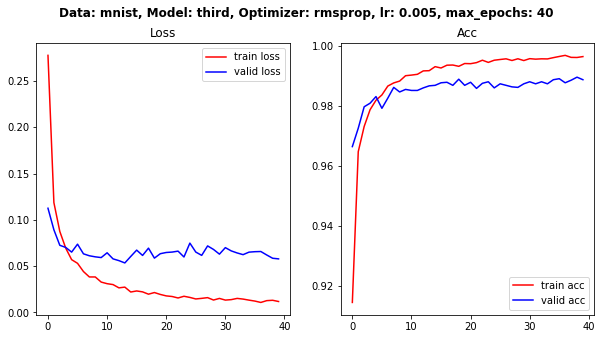

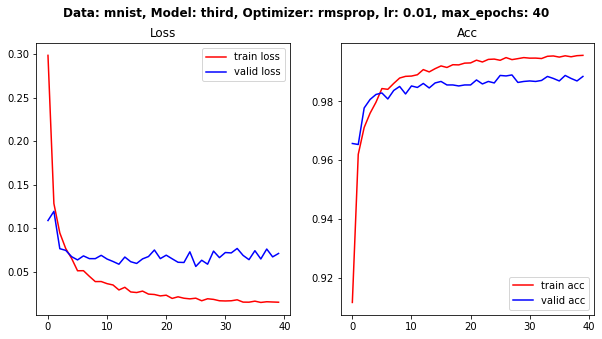

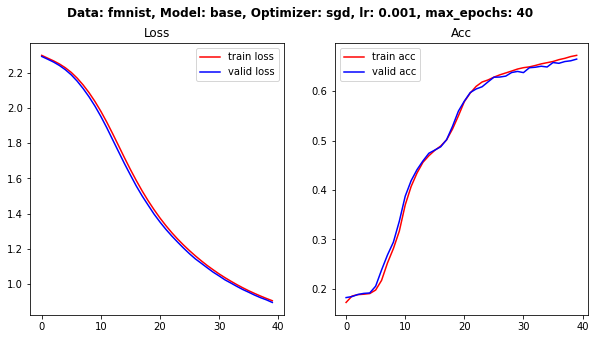

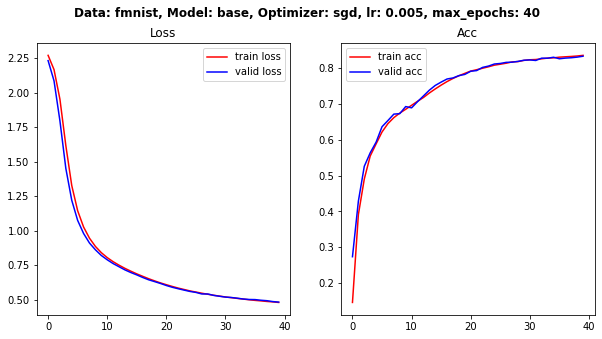

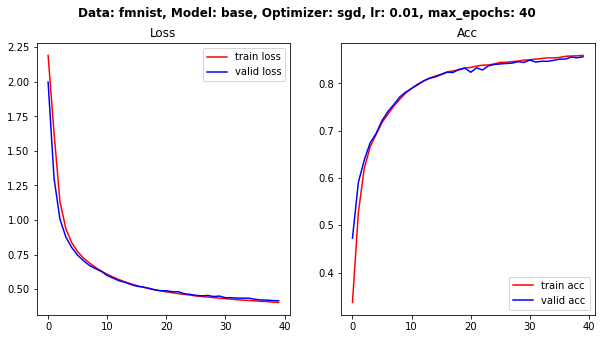

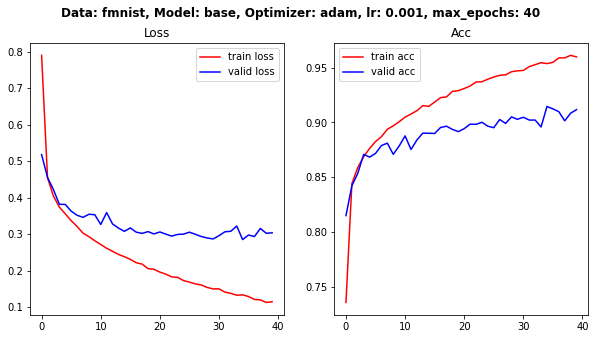

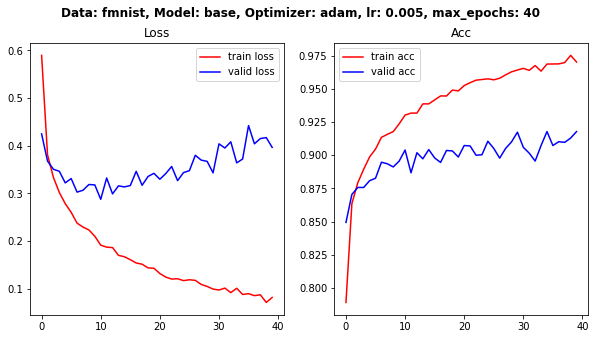

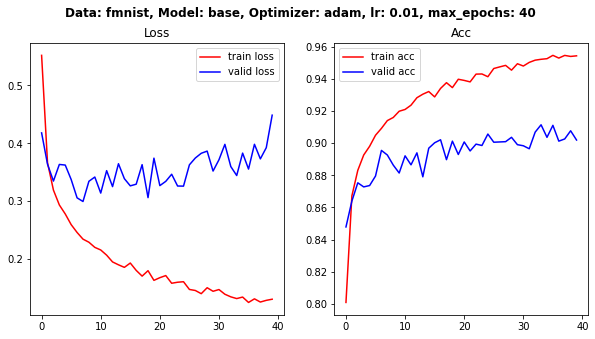

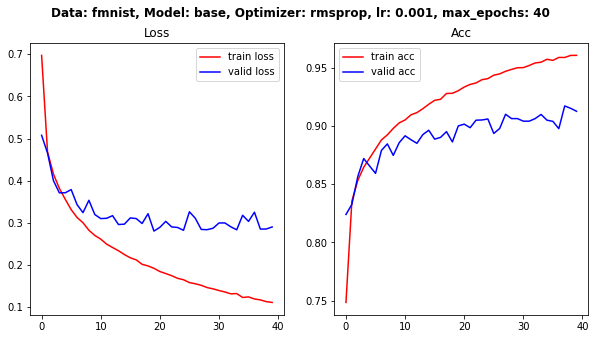

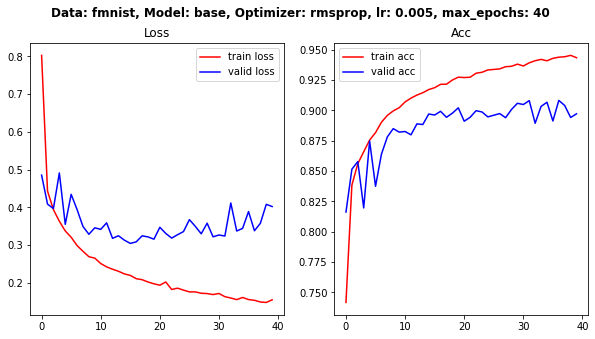

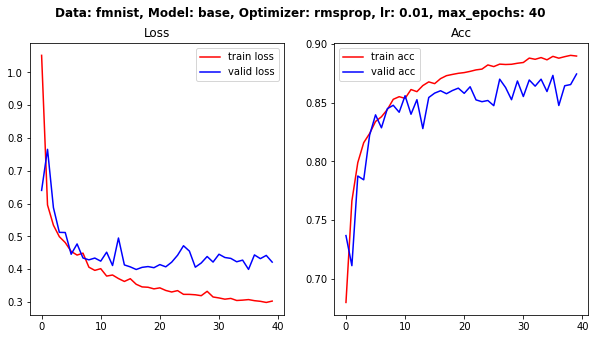

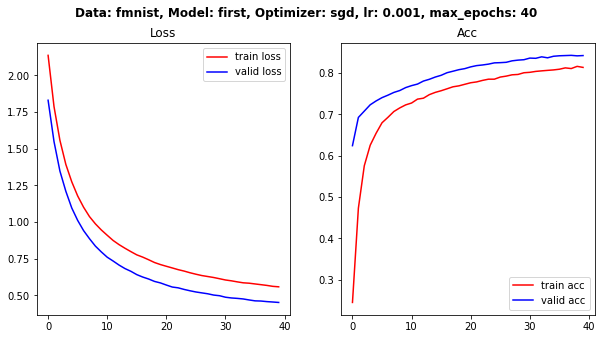

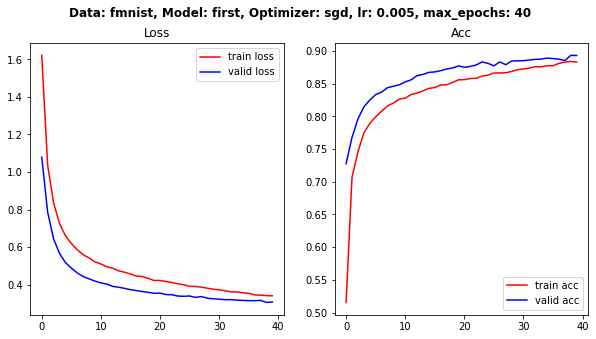

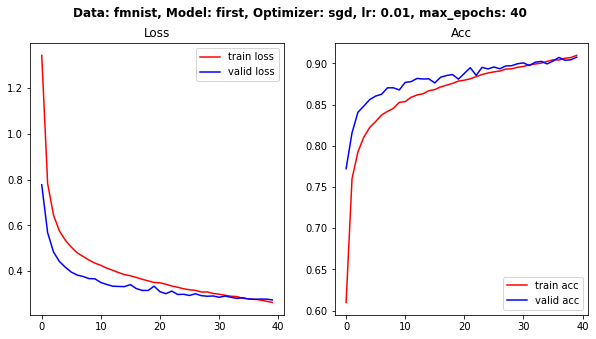

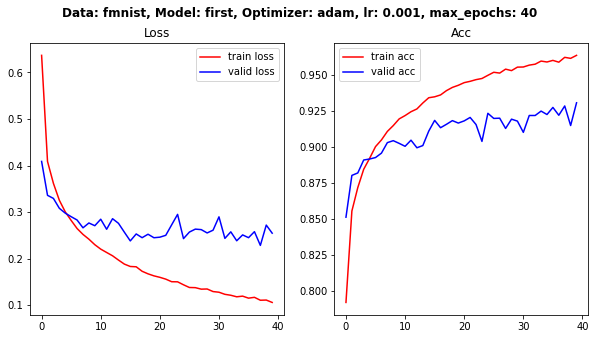

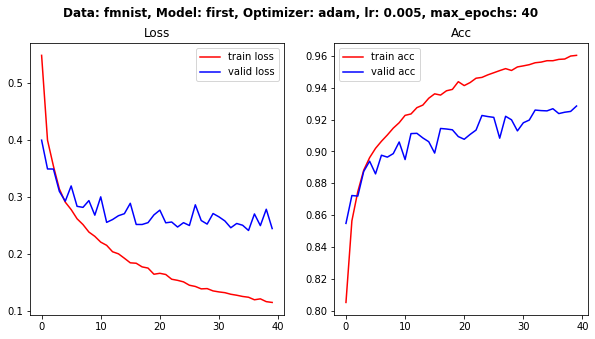

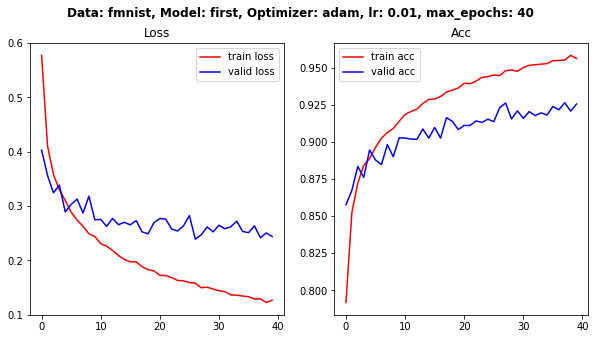

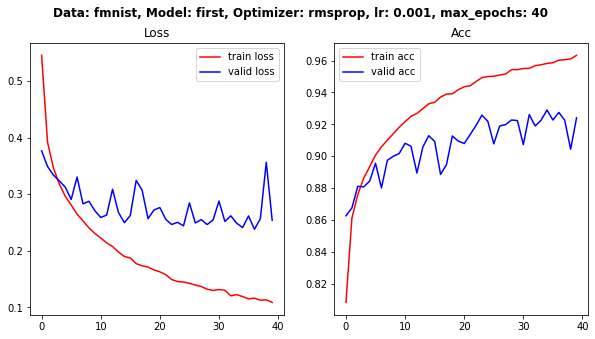

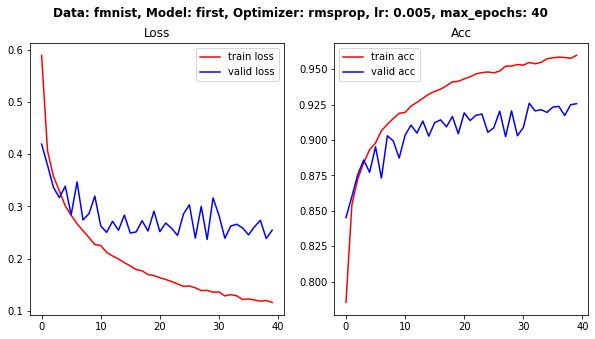

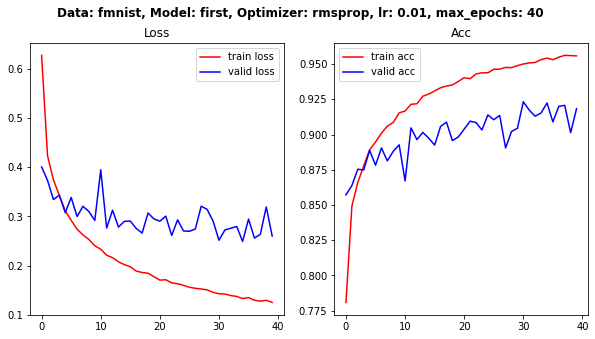

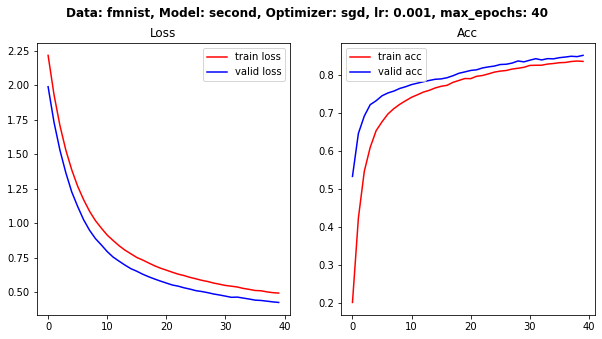

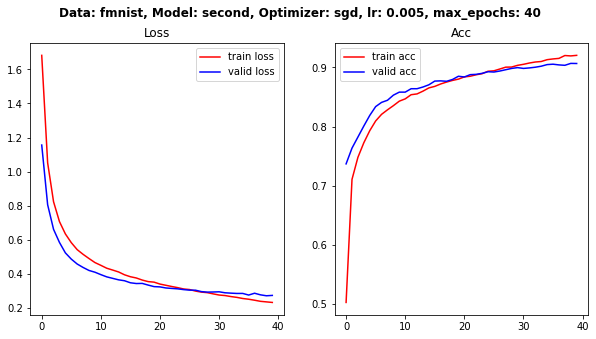

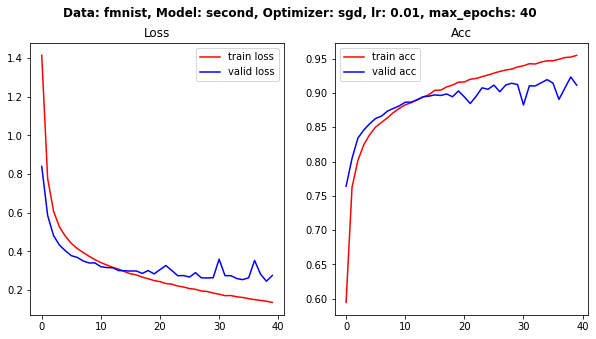

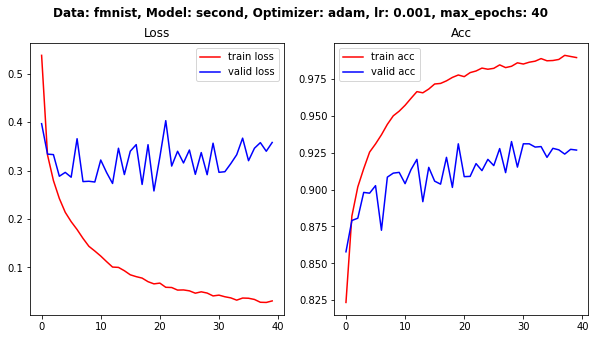

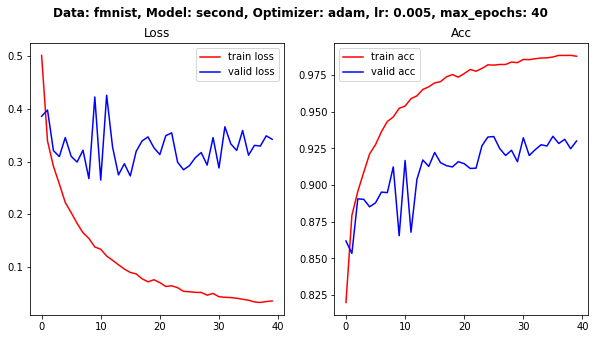

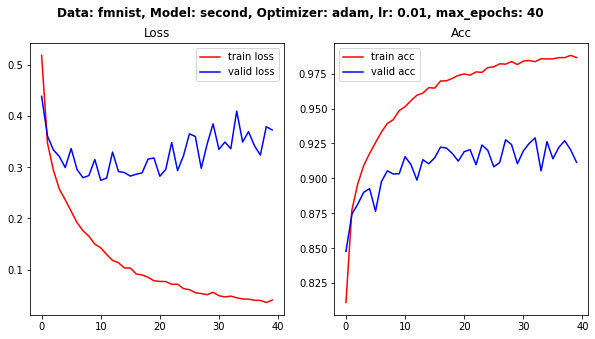

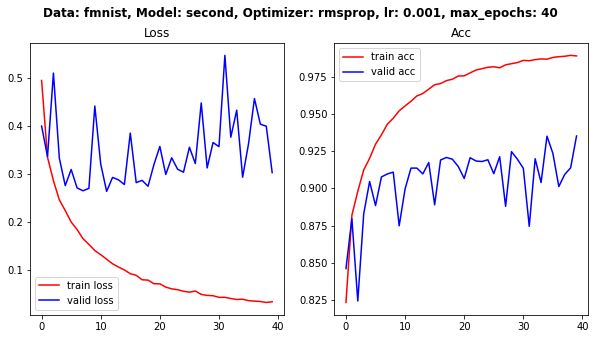

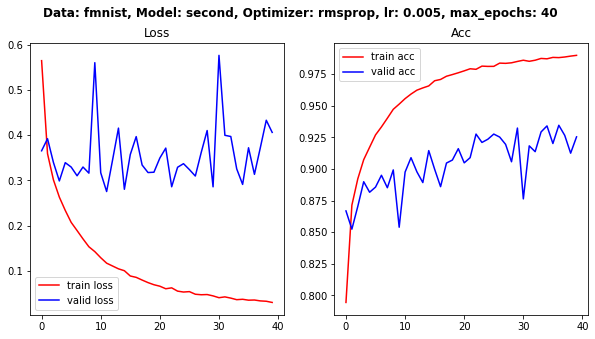

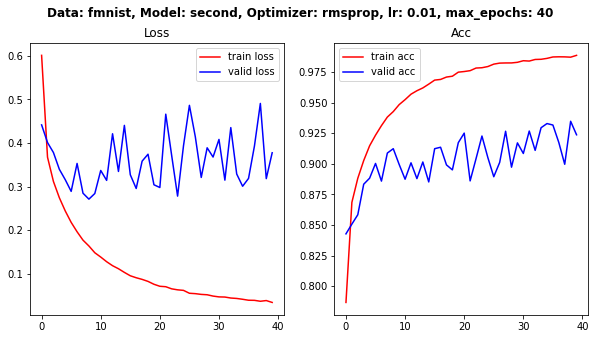

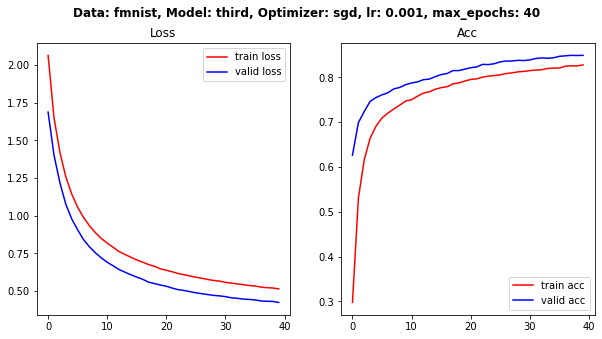

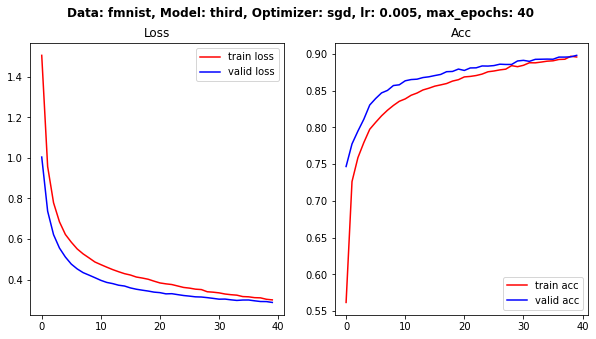

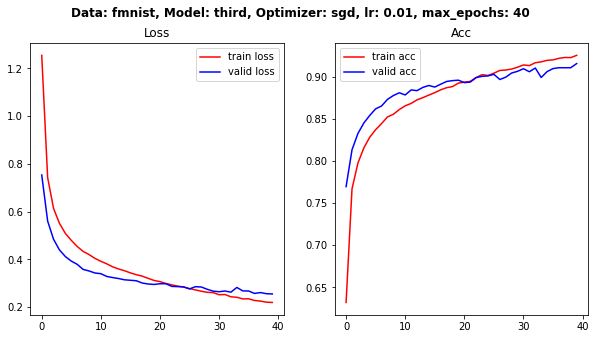

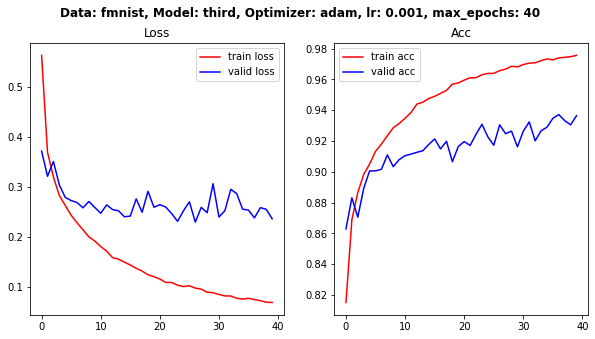

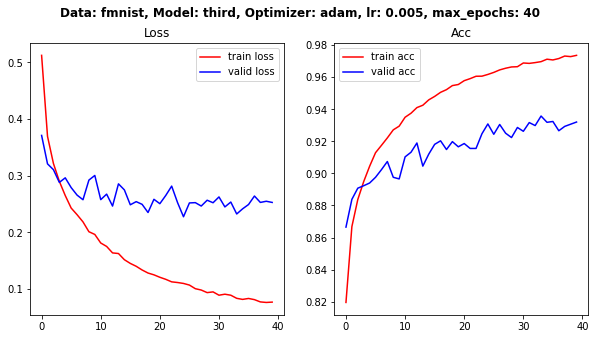

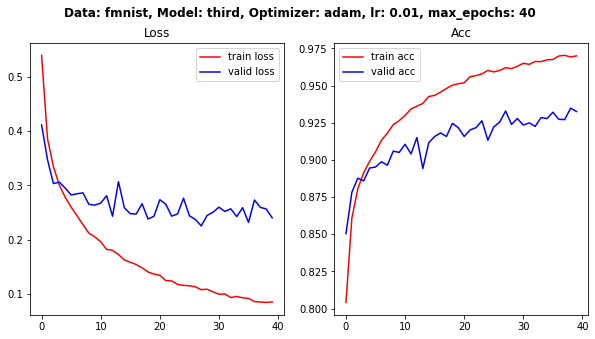

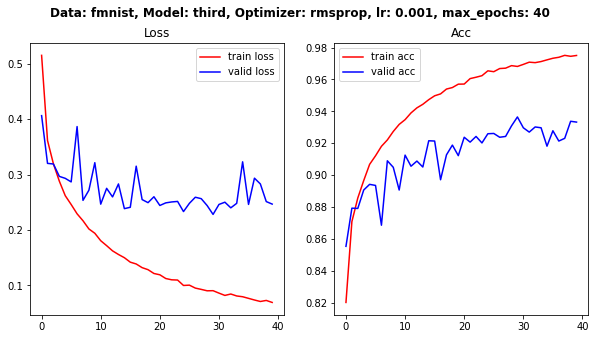

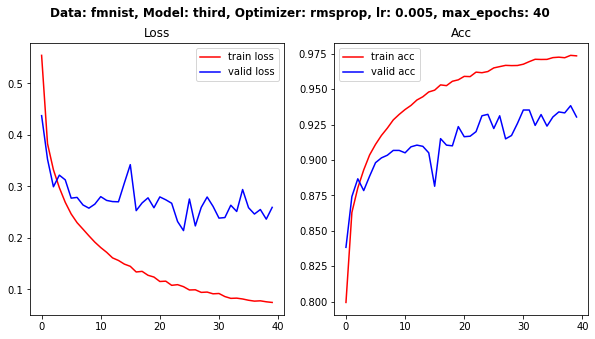

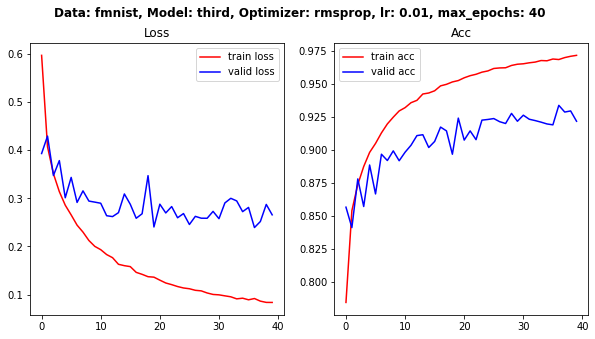

In [ ]:
for d in ds:
  for m in models:
    for opt in opts:
      for lr in lrs:
        model = get_model(model_name = m)
        trainer = Trainer(model=model, opt=opt, lr=lr)
        print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
        start_time = time.time()
        trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
        print(f"Training time : {time.time()-start_time:>3f}")
        trainer.test(test_loader=datas[d][2])

* 그래프 보고 overfitting안된거 중에 성능 우수한거 몇개면 epoch 늘려서 다시 해보기
* 모델 1층, 2층 더 쌓아서 하나 더 해보기. 2개 해보기.
* mnist, third, adam, 0.01, epoch 50 기반 
* fmnist, third, adam 0.01, 0.001  // third, rmsprop, 0.001

In [ ]:
ds = ["mnist", "fmnist"]
models = ["fourth", "fifth"]
opts = ["adam"]
lrs = [0.001, 0.01]
max_epochs = 50

===== Data: mnist, Model: fourth, Optimizer: adam, lr: 0.001, max_epochs: 50 =====
===== Train Start =====
Epoch: 0, train loss: 0.424903, train acc: 0.884989, valid loss: 0.143037, valid acc: 0.959239, time: 9.255414
Epoch: 5, train loss: 0.065898, train acc: 0.980153, valid loss: 0.073462, valid acc: 0.980129, time: 44.453174
Epoch: 10, train loss: 0.042000, train acc: 0.987519, valid loss: 0.064804, valid acc: 0.983696, time: 43.398078
Epoch: 15, train loss: 0.031832, train acc: 0.990365, valid loss: 0.053609, valid acc: 0.985054, time: 45.154238
Epoch: 20, train loss: 0.023804, train acc: 0.993006, valid loss: 0.060696, valid acc: 0.985394, time: 44.229839
Epoch: 25, train loss: 0.021226, train acc: 0.993750, valid loss: 0.052751, valid acc: 0.988961, time: 44.089692
Epoch: 30, train loss: 0.015603, train acc: 0.995517, valid loss: 0.059203, valid acc: 0.986753, time: 43.691364
Epoch: 35, train loss: 0.014867, train acc: 0.995368, valid loss: 0.058319, valid acc: 0.985734, time: 45

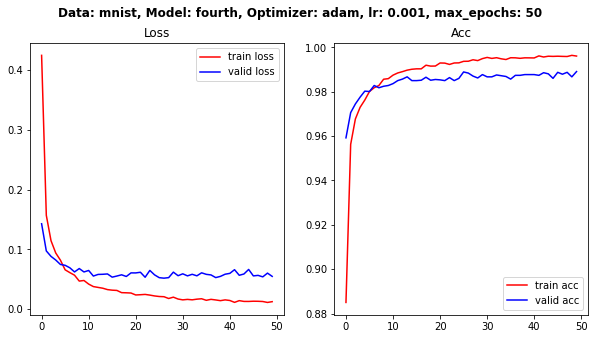

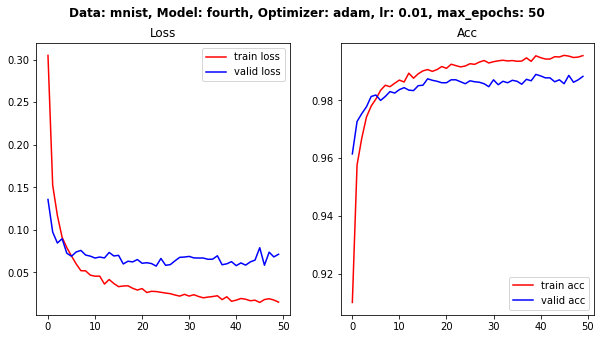

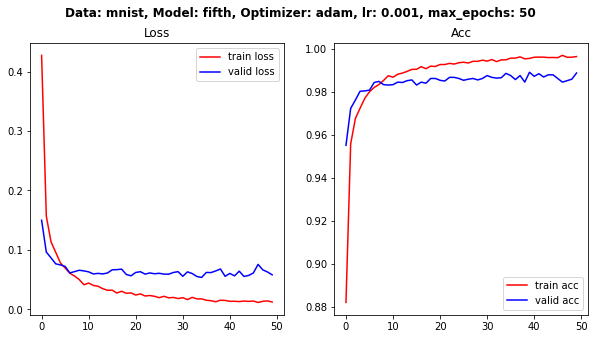

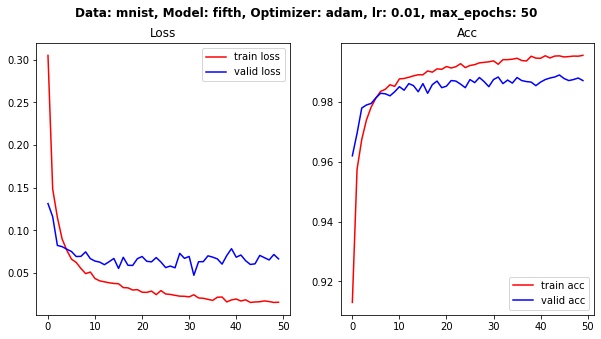

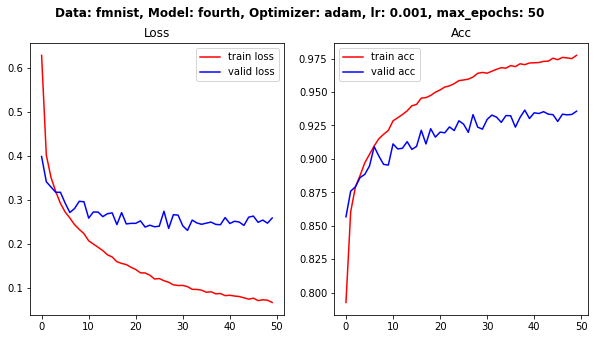

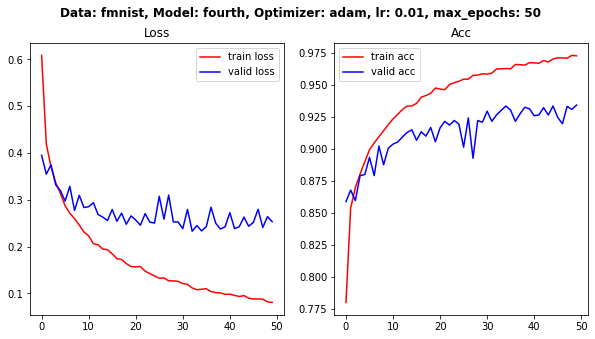

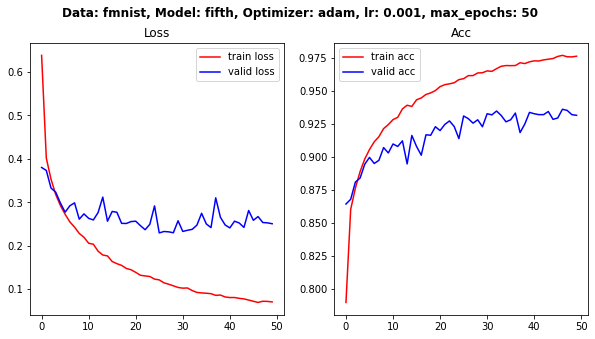

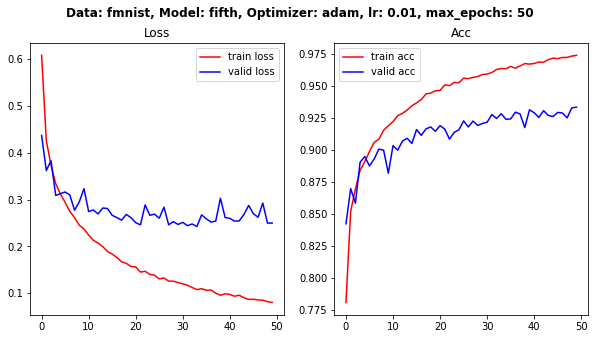

In [ ]:
for d in ds:
  for m in models:
    for opt in opts:
      for lr in lrs:
        model = get_model(model_name = m)
        trainer = Trainer(model=model, opt=opt, lr=lr)
        print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
        start_time = time.time()
        trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
        print(f"Training time : {time.time()-start_time:>3f}")
        trainer.test(test_loader=datas[d][2])

In [ ]:
ds = ["mnist", "fmnist"]
models = ["fourth", "fifth"]
opts = ["rmsprop"]
lrs = [0.001, 0.01]
max_epochs = 50

===== Data: mnist, Model: fourth, Optimizer: rmsprop, lr: 0.001, max_epochs: 50 =====
===== Train Start =====
Epoch: 0, train loss: 0.300708, train acc: 0.913914, valid loss: 0.125148, valid acc: 0.963315, time: 9.009680
Epoch: 5, train loss: 0.066391, train acc: 0.980785, valid loss: 0.079440, valid acc: 0.976902, time: 46.380905
Epoch: 10, train loss: 0.038556, train acc: 0.988356, valid loss: 0.056573, valid acc: 0.983696, time: 44.603568
Epoch: 15, train loss: 0.030957, train acc: 0.990420, valid loss: 0.054061, valid acc: 0.986243, time: 44.845878
Epoch: 20, train loss: 0.024857, train acc: 0.992336, valid loss: 0.062006, valid acc: 0.985394, time: 45.360633
Epoch: 25, train loss: 0.020343, train acc: 0.994029, valid loss: 0.056734, valid acc: 0.987432, time: 46.004359
Epoch: 30, train loss: 0.015712, train acc: 0.995275, valid loss: 0.055538, valid acc: 0.987092, time: 46.788047
Epoch: 35, train loss: 0.015117, train acc: 0.995480, valid loss: 0.061504, valid acc: 0.987772, time:

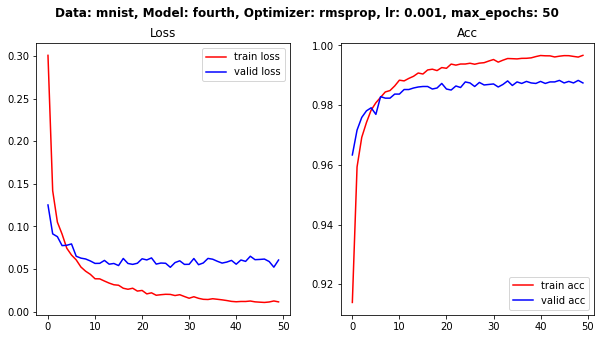

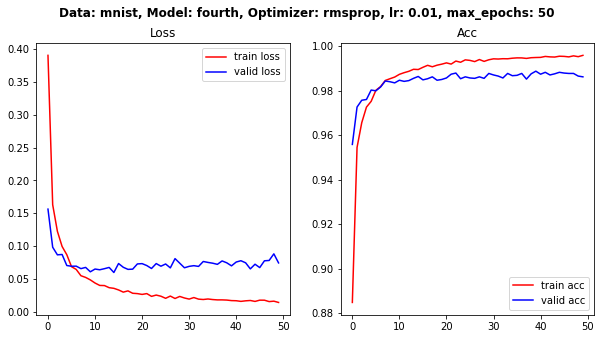

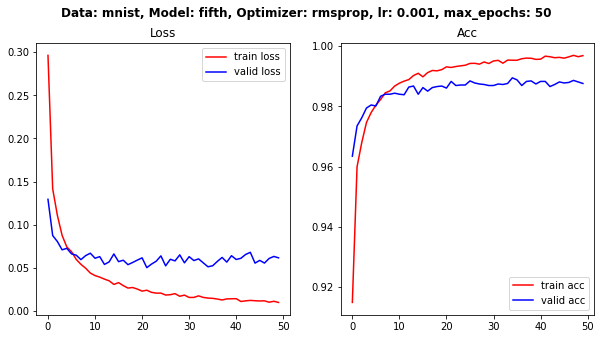

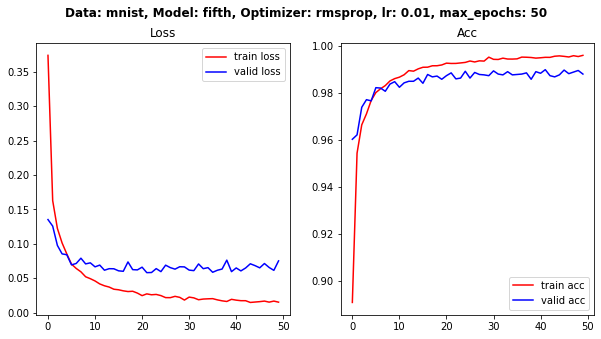

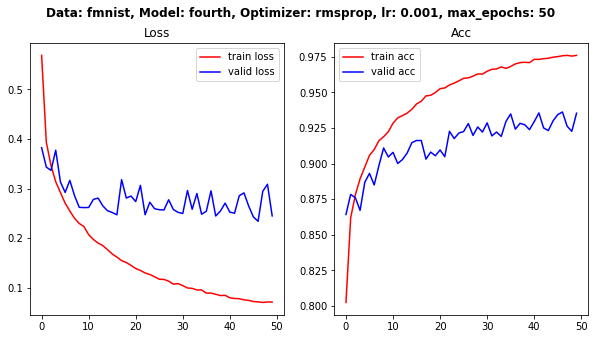

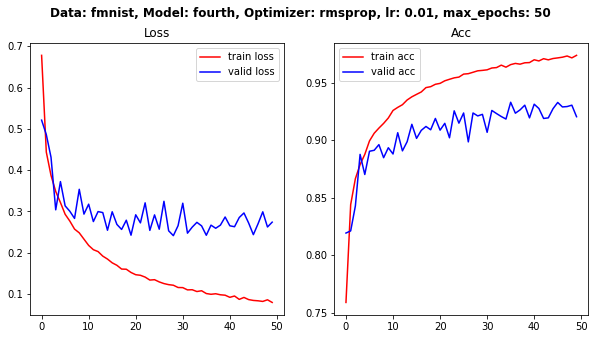

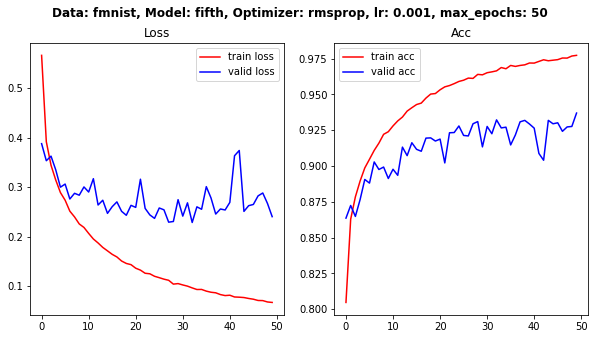

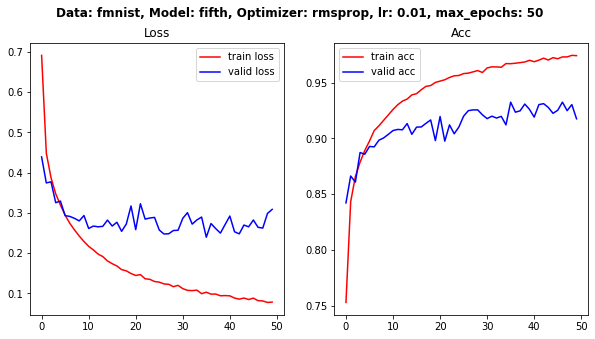

In [ ]:
for d in ds:
  for m in models:
    for opt in opts:
      for lr in lrs:
        model = get_model(model_name = m)
        trainer = Trainer(model=model, opt=opt, lr=lr)
        print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
        start_time = time.time()
        trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
        print(f"Training time : {time.time()-start_time:>3f}")
        trainer.test(test_loader=datas[d][2])

In [ ]:
ds = ["mnist"]
models = ["fifth", "seventh"]
opts = ["adam"]
lrs = [0.001]
max_epochs = 100

===== Data: mnist, Model: fifth, Optimizer: adam, lr: 0.001, max_epochs: 100 =====
===== Train Start =====
Epoch: 0, train loss: 0.437795, train acc: 0.879167, valid loss: 0.135579, valid acc: 0.960598, time: 9.157301
Epoch: 5, train loss: 0.067194, train acc: 0.979929, valid loss: 0.071731, valid acc: 0.980978, time: 46.455029
Epoch: 10, train loss: 0.042925, train acc: 0.987221, valid loss: 0.066525, valid acc: 0.982507, time: 47.964710
Epoch: 15, train loss: 0.027973, train acc: 0.992132, valid loss: 0.065979, valid acc: 0.984885, time: 47.505844
Epoch: 20, train loss: 0.025878, train acc: 0.992392, valid loss: 0.061098, valid acc: 0.987772, time: 45.850022
Epoch: 25, train loss: 0.021177, train acc: 0.993527, valid loss: 0.061269, valid acc: 0.987262, time: 46.793202
Epoch: 30, train loss: 0.018027, train acc: 0.994513, valid loss: 0.055164, valid acc: 0.987772, time: 46.559114
Epoch: 35, train loss: 0.016300, train acc: 0.995052, valid loss: 0.060163, valid acc: 0.986583, time: 45

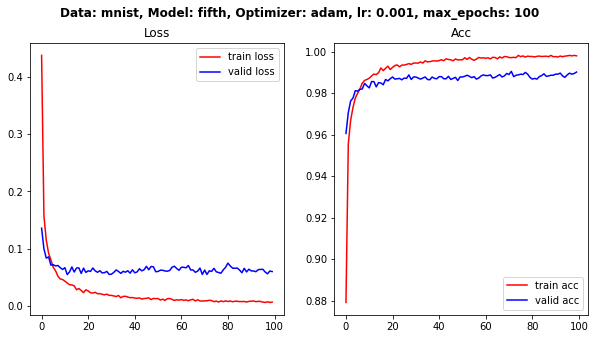

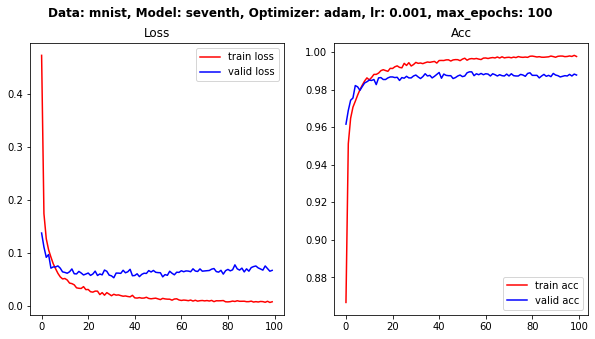

In [ ]:
for d in ds:
  for m in models:
    for opt in opts:
      for lr in lrs:
        model = get_model(model_name = m)
        trainer = Trainer(model=model, opt=opt, lr=lr)
        print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
        start_time = time.time()
        trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
        print(f"Training time : {time.time()-start_time:>3f}")
        trainer.test(test_loader=datas[d][2])

In [ ]:
ds = ["fmnist"]
models = ["fourth", "sixth"]
opts = ["adam"]
lrs = [0.001]
max_epochs = 100

===== Data: fmnist, Model: fourth, Optimizer: adam, lr: 0.001, max_epochs: 100 =====
===== Train Start =====
Epoch: 0, train loss: 0.626131, train acc: 0.794048, valid loss: 0.381661, valid acc: 0.865149, time: 9.366259
Epoch: 5, train loss: 0.274945, train acc: 0.902809, valid loss: 0.291111, valid acc: 0.897079, time: 44.536737
Epoch: 10, train loss: 0.207847, train acc: 0.928330, valid loss: 0.278464, valid acc: 0.900476, time: 44.689004
Epoch: 15, train loss: 0.164582, train acc: 0.943973, valid loss: 0.245128, valid acc: 0.917289, time: 44.658360
Epoch: 20, train loss: 0.139020, train acc: 0.952548, valid loss: 0.245443, valid acc: 0.922215, time: 45.952585
Epoch: 25, train loss: 0.123345, train acc: 0.956882, valid loss: 0.246350, valid acc: 0.924253, time: 44.756693
Epoch: 30, train loss: 0.104161, train acc: 0.964974, valid loss: 0.251935, valid acc: 0.926291, time: 48.402034
Epoch: 35, train loss: 0.092706, train acc: 0.968545, valid loss: 0.235949, valid acc: 0.935292, time: 

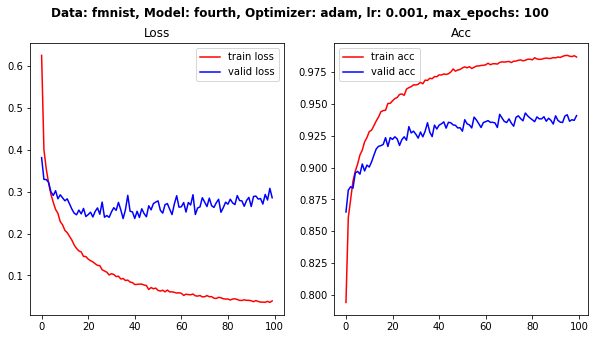

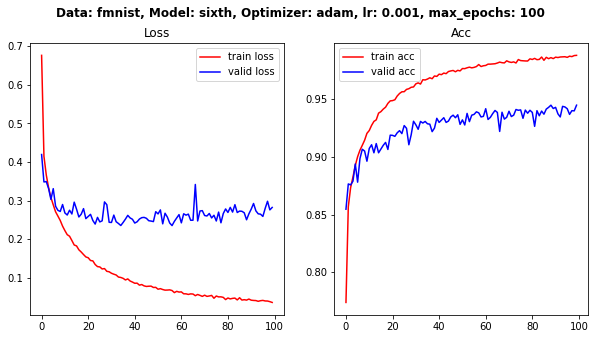

In [ ]:
for d in ds:
  for m in models:
    for opt in opts:
      for lr in lrs:
        model = get_model(model_name = m)
        trainer = Trainer(model=model, opt=opt, lr=lr)
        print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
        start_time = time.time()
        trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
        print(f"Training time : {time.time()-start_time:>3f}")
        trainer.test(test_loader=datas[d][2])

In [ ]:
ds = ["fmnist"]
models = ["sixth"]
opts = ["rmsprop"]
lrs = [0.01, 0.001]
max_epochs = 100

===== Data: fmnist, Model: sixth, Optimizer: rmsprop, lr: 0.01, max_epochs: 100 =====
===== Train Start =====
Epoch: 0, train loss: 0.718653, train acc: 0.745871, valid loss: 0.493591, valid acc: 0.834409, time: 11.228888
Epoch: 5, train loss: 0.311215, train acc: 0.893545, valid loss: 0.425500, valid acc: 0.855129, time: 59.911370
Epoch: 10, train loss: 0.229049, train acc: 0.921726, valid loss: 0.283898, valid acc: 0.905231, time: 55.116986
Epoch: 15, train loss: 0.188817, train acc: 0.936384, valid loss: 0.283138, valid acc: 0.913213, time: 57.160391
Epoch: 20, train loss: 0.157401, train acc: 0.947489, valid loss: 0.264257, valid acc: 0.914402, time: 54.595695
Epoch: 25, train loss: 0.139514, train acc: 0.954092, valid loss: 0.283238, valid acc: 0.918139, time: 54.373233
Epoch: 30, train loss: 0.124397, train acc: 0.959821, valid loss: 0.242869, valid acc: 0.924762, time: 55.930617
Epoch: 35, train loss: 0.107851, train acc: 0.963839, valid loss: 0.263788, valid acc: 0.918988, time

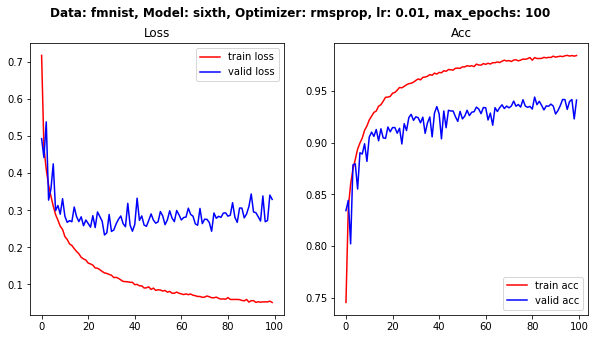

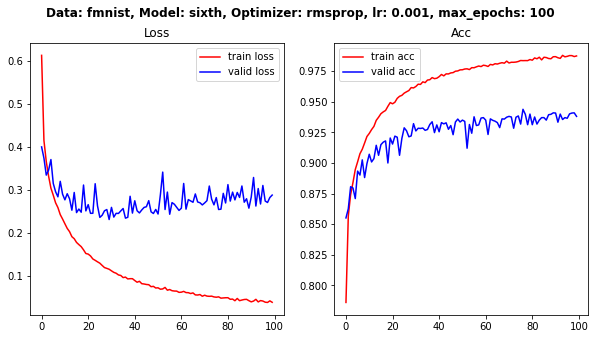

In [ ]:
for d in ds:
  for m in models:
    for opt in opts:
      for lr in lrs:
        model = get_model(model_name = m)
        trainer = Trainer(model=model, opt=opt, lr=lr)
        print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
        start_time = time.time()
        trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
        print(f"Training time : {time.time()-start_time:>3f}")
        trainer.test(test_loader=datas[d][2])

# Best Model

===== Data: mnist, Model: seventh, Optimizer: adam, lr: 0.001, max_epochs: 100 =====
===== Train Start =====
Epoch: 0, train loss: 0.476627, train acc: 0.864788, valid loss: 0.151805, valid acc: 0.956692, time: 11.873566
Epoch: 5, train loss: 0.076061, train acc: 0.978441, valid loss: 0.082432, valid acc: 0.978770, time: 57.302764
Epoch: 10, train loss: 0.049898, train acc: 0.985900, valid loss: 0.063670, valid acc: 0.984035, time: 57.132691
Epoch: 15, train loss: 0.036518, train acc: 0.989174, valid loss: 0.061677, valid acc: 0.984545, time: 58.030380
Epoch: 20, train loss: 0.028546, train acc: 0.991369, valid loss: 0.063653, valid acc: 0.985564, time: 58.067538
Epoch: 25, train loss: 0.024234, train acc: 0.993025, valid loss: 0.058893, valid acc: 0.986073, time: 57.195926
Epoch: 30, train loss: 0.021224, train acc: 0.993750, valid loss: 0.062922, valid acc: 0.986073, time: 57.823314
Epoch: 35, train loss: 0.016289, train acc: 0.995089, valid loss: 0.058992, valid acc: 0.986243, time:

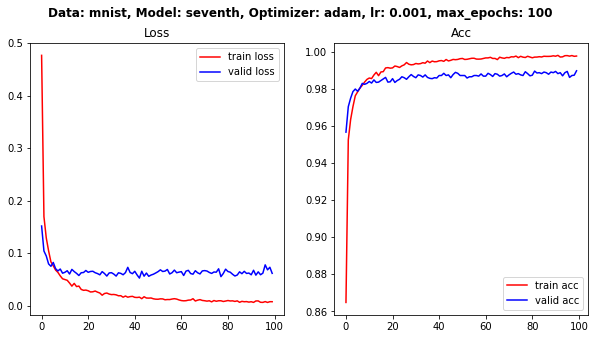

In [ ]:
# MNIST dataset에 대해 여러분이 찾은 최적의 조건으로 학습을 한 번 더 진행
d = "mnist"
m = "seventh"
opt = "adam"
lr = 0.001
max_epochs = 100

model = get_model(model_name = m)
trainer = Trainer(model=model, opt=opt, lr=lr)
print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
trainer.test(test_loader=datas[d][2])

===== Data: fmnist, Model: sixth, Optimizer: adam, lr: 0.001, max_epochs: 100 =====
===== Train Start =====
Epoch: 0, train loss: 0.667909, train acc: 0.779185, valid loss: 0.401618, valid acc: 0.858526, time: 13.089569
Epoch: 5, train loss: 0.289381, train acc: 0.899089, valid loss: 0.312454, valid acc: 0.887228, time: 59.422012
Epoch: 10, train loss: 0.222997, train acc: 0.924461, valid loss: 0.267375, valid acc: 0.908118, time: 59.546872
Epoch: 15, train loss: 0.177032, train acc: 0.940011, valid loss: 0.252882, valid acc: 0.913723, time: 59.564145
Epoch: 20, train loss: 0.147674, train acc: 0.950818, valid loss: 0.243131, valid acc: 0.921705, time: 57.675561
Epoch: 25, train loss: 0.125213, train acc: 0.958240, valid loss: 0.238359, valid acc: 0.923064, time: 57.220770
Epoch: 30, train loss: 0.111641, train acc: 0.962072, valid loss: 0.244387, valid acc: 0.931895, time: 61.849103
Epoch: 35, train loss: 0.098637, train acc: 0.967020, valid loss: 0.250589, valid acc: 0.926461, time: 

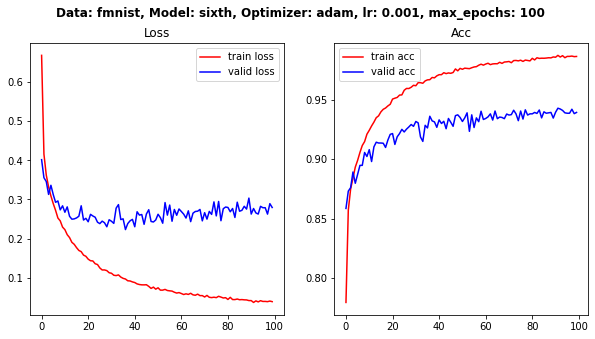

In [ ]:
# FashionMNIST dataset에 대해 여러분이 찾은 최적의 조건으로 학습을 한 번 더 진행
d = "fmnist"
m = "sixth"
opt = "adam"
lr = 0.001
max_epochs = 100

model = get_model(model_name = m)
trainer = Trainer(model=model, opt=opt, lr=lr)
print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
trainer.test(test_loader=datas[d][2])